# Monte-Carlo Simulations in Astrophysics

Physical processes in space often involve the description of the behavior of a great number of elements in bulk. Usually, physicists deal with these objects by considering them directly in bulk, and deriving analytical descriptions to their behavior, or interactions. These descriptions sometimes require numerical integration in order to predict the behavior of a whole system. However, it is sometimes very difficult to numerically keep track of these physical quantites accurately. Some physical processes also involve a part of randomness that is hard to capture.

Thankfully it is possible for a range of problems build a probabilistic description of the behavior of each element. And it makes it possible to recover these integrated physical quantities in simulations, as long as we accurately account for the probability distributions involved and build a good enough statistic.

These are **Monte-Carlo methods**. A Monte-carlo simulation does not necessarily model random processes. It can be a probabilistic approach to solving a deterministic problem. Each individual process happening in the simulation is deterministic in real life, but thanks to the fact that we know the total probability distribution for the outcomes of each of them, we can randomly draw an outcome for every one of these events. By summing up several instances of the simulations we obtain the posterior distributions of each of our measured quantities, often reducing to a single number if our statistic is good enough.

## Random Number Generators

A computer is a deterministic machine. How can we generate a sequence of numbers that look random?
Well I already gave it away by saying "look random". We generate **pseudo-random numbers**, a sequence of numbers that where each new draw depends on the previous one, but in a way so obscure that it doesn't make sense to humans.

Criteria for a good pseudo-random sequence:

- Good distribution
- Long period
- Repeatability
- Long disjoint subsequences
- Efficiency



#### Linear Congruential Random Number Generator

This is the most basic random number generator and is defined by:

$$X_{n+1} = (a X_n + c) \mod m$$

The choice of $a$, $c$ and $m$ are crucial for this generator to respect the criteria listed above. A good set of parameters is $a = 7^5 = 16807$, $c=0$ and $m = 2^{31} - 1 = 2147483647$.

In [4]:
import numpy as np
class LinearCongruentialRandGen:
    """docstring for LinearCongruentialRandGen"""
    def __init__(self, a = 16807, m = 2147483647, c = 0, seed = 1):
        self.a = a
        self.m = m
        self.c = c
        self.seed = seed
        self.guess = seed

    def draw(self):
        self.guess = (self.a * self.guess + self.c)%self.m
        return self.guess
    
    def uniform(self, N=1, a=0., b=1.):
        return np.array([(self.draw() / (self.m - 1)) * (b-a) + a for i in range(N)])

##### Frequency test:

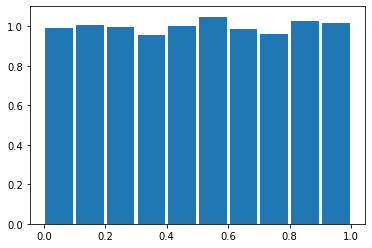

In [48]:
import matplotlib.pyplot as plt
rand = LinearCongruentialRandGen()
plt.hist(rand.uniform(10000), 10, rwidth=0.9, density=True)
plt.show()

##### Random numbers in multi-dimensions

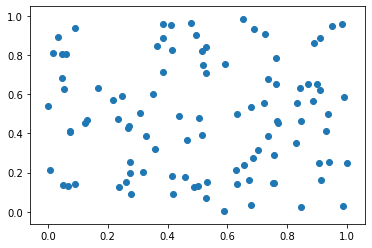

In [5]:
import matplotlib.pyplot as plt
rand = LinearCongruentialRandGen()
plt.scatter(rand.uniform(100), rand.uniform(100))
plt.show()

**Careful!** Our generator is **pseudo-random**!

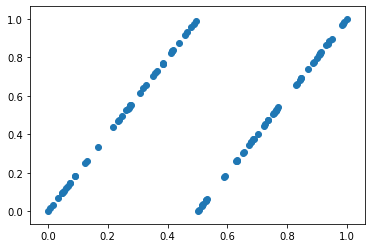

In [26]:
import matplotlib.pyplot as plt
rand1 = LinearCongruentialRandGen(seed=1)
rand2 = LinearCongruentialRandGen(seed=2)   # We initialize a second random number generator with a
                                            # slightly different seed for the y-coordinate.
                                            # x and y will be correlated and not independent anymore!
plt.scatter(rand1.uniform(100), rand2.uniform(100))
plt.show()

## Monte-Carlo integration:

In many problems, we have to compute multi-dimensional integrals. The classic quadrature techniques (Riemann integrals) quickly scale up with the number of dimensions have difficulty converging efficiently.

Monte-Carlo methods have the advantage of converging at a rate of $1/\sqrt{N}$ regardless of the number of dimensions and are thus the **methods of choice for the integration of highly dimensional problems**.

Consider a function $f(x) = f(u_1, ..., u_d)$ on a d-dimensional space. The Monte-Carlo estimate for the integral:
$$I = \int f(x) \mathrm{d}x$$
is given by:
$$E = \frac{1}{N} \sum_{i=0}^{N-1} f(x_n).$$

The difference with standard numerical integration is that the sequence $(x_n)_{n \in [0,N-1]}$ is drawn randomly from the d-dimensional space.

The technique can be applied both to data-analysis (MCMC) and numerical simulations in which we need to compute the integrals of complex functions depending on a lot of parameters.

#### Application: Computing the value of pi

We are going to compute the following integral:

$$\int_0^1\int_0^1 f(x,y) \mathrm{d}x \mathrm{d}y, = \frac{\pi}{4}$$

$$f(x,y) = 1 \text{ if } x^2+y^2 \leq 1, ~0 \text{ otherwise}.$$

pi ~= 3.152000


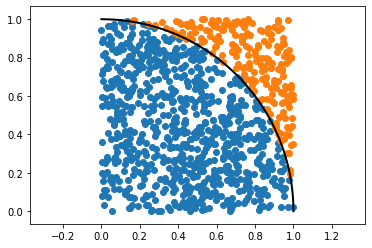

In [96]:
import matplotlib.pyplot as plt

nsample = 1000

rand = LinearCongruentialRandGen()
x = rand.uniform(nsample)
y = rand.uniform(nsample)

mask = x**2 + y**2 < 1
print("pi ~= %f" %(4 * np.sum(mask)/x.shape[0]))

plt.scatter(x[mask],y[mask])
plt.scatter(x[~mask], y[~mask])
x_th = np.linspace(0, 1, 1000)
plt.plot(x_th, 
        np.sqrt(1 - x_th**2), 'k', lw=2)
plt.axis("equal")
plt.show()

## Sampling from non-uniform distribution

Sampling from uniform distribution is nice. Very often, though, we need to sample from non-uniform distributions. This is the case for exponential decay events for example (radioactive decay, scattering events), or when we sample from normal distributions for in the Metropolis-Hastings method used in MCMC.

The approaches range from very easy to implement, but computationally wasteful, to much harder (or requiring lots of pen and paper calculations),  but much more efficient. The choice of method depends on the complexity of the probability density function, some of the methods sometimes being inapplicable.

#### Direct Mapping

This is what we did when we made the uniform random number generator able to cover any interval. We knew a direct transformation from the uniform distribution [0,1] to [a,b].

Another classic example involves sampling from an exponential distribution:

$$p(x)\mathrm{d}x = \lambda e^{-\lambda x} \mathrm{d}x$$

In [66]:
def expDensityFunction(x, lbda = 1):
    return lbda * np.exp(-lbda * x)

If we operate a change of variable $y = e^{-\lambda x}$, we get the following expression for the pdf:

$$\lambda e^{-\lambda x} \mathrm{d}x = dy$$

We can thus sample y uniformly and take $x = - \ln(x) / \lambda$.

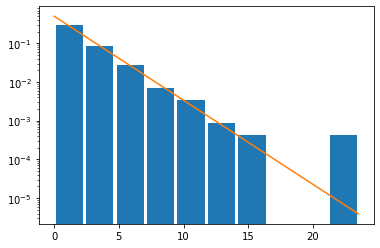

In [67]:
import matplotlib.pyplot as plt

lbda = 0.5
nsample = 1000

rand = LinearCongruentialRandGen()
u = rand.uniform(nsample)
x = -np.log(u) / lbda

hist, bins, patches = plt.hist(x, 10, rwidth=0.9, density=True)
plt.plot(np.linspace(bins[0], bins[-1], 1000), 
        expDensityFunction(np.linspace(bins[0], bins[-1], 1000), lbda))
plt.yscale('log')

#### Rejection method

Recall the monte-carlo integration we carried out for the calculation of $\pi$.

The rejection pethod works in a similar way. We sample $x$ uniformly in a volume of dimension $d+1$ containing the pdf we want to draw from. If $x_{d+1} > f(x_1,...,x_d)$ we reject the sample and draw another one. Eventually, we get a distribution of samples in d-space following the function $f$.

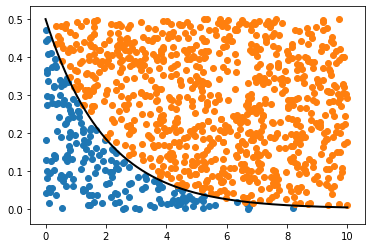

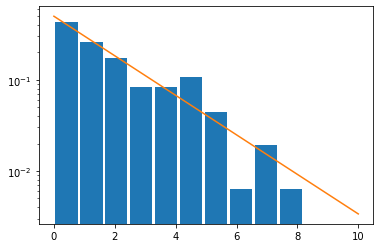

In [79]:
import matplotlib.pyplot as plt

lbda    = 0.5
nsample = 1000
xmin    = 0
xmax    = 10

rand = LinearCongruentialRandGen()
x = rand.uniform(nsample, xmin, xmax)
y = rand.uniform(nsample, 0, lbda)

mask = y < expDensityFunction(x, lbda)

plt.scatter(x[mask],y[mask])
plt.scatter(x[~mask], y[~mask])
plt.plot(np.linspace(xmin, xmax, 1000), 
        expDensityFunction(np.linspace(xmin, xmax, 1000), lbda), 'k', lw=2)
plt.show()

hist, bins, patches = plt.hist(x[mask], 10, rwidth=0.9, density=True)
plt.plot(np.linspace(xmin, xmax, 1000), 
        expDensityFunction(np.linspace(xmin, xmax, 1000), lbda))
plt.yscale('log')
plt.show()

**By comparing the direct mapping and the rejection method frequency tests we can already see that the rejection is very computationally wasteful.**

#### Metropolis-Hastings method

We want to sample $P(x)$. The Metropolis algorithm is a **Markov process**, that is a sampling method that relies on the calculation of transition probabilities $P(x^\prime|x)$ from one sample $x$ to another $x^\prime$.

We start from a random sample in space. We then guess another sample according to a candidate distribution $Q(x^\prime|x)$. The transition probability is given by: 

$$a = \frac{P(x^\prime)}{P(x)} \frac{Q(x|x^\prime)}{Q(x^\prime|x)}$$

This method is often used for fitting the parameters of highly-dimensional models as they cope better with the curse of dimensionality than other Monte-Carlo methods.

Two downsides to using this method are:
- The burn-in period when starting from a random sample in a low-probability region of the parameter-space.
- The samples are correlated. This is often addressed by only storing samples every given number of iterations, at the cost of computational efficiency.

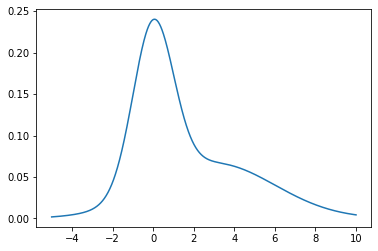

In [223]:
import matplotlib.pyplot as plt

def f(x):
    return(1./np.sqrt(2.*np.pi) * np.exp(-x**2/2.) /2.
           + 1./(3*np.sqrt(2.*np.pi)) * np.exp(-((x-3.)/3.)**2 / 2.) / 2.)

def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2.)

plt.plot(np.linspace(-5, 10, 1000), f(np.linspace(-5,10,1000)))
plt.show()

In [180]:
from numpy.random import normal, uniform

def Metropolis(f=None, nsample=100, intrvl=[0,1], xstart=None):        
    sigma = 1.
    
    if xstart is None: 
        xstart=uniform(*intrvl,1)[0]
    
    res = [xstart]
    x = xstart
    for i in range(nsample):
        xguess = normal(x,sigma,1)[0]
        a = f(xguess) / f(x) * gaussian(x, xguess, sigma) / gaussian(xguess, x, sigma)
        if uniform() < a:
            x = xguess
        res.append(x)
        
    return np.array(res)

In [181]:
x = Metropolis(f, 10000, [-5, 10])

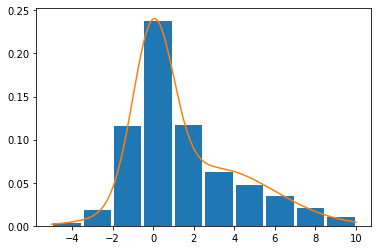

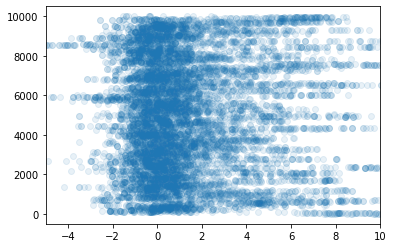

In [182]:
plt.hist(x, 10, range=(-5, 10), rwidth=0.9, density=True)
plt.plot(np.linspace(-5, 10, 1000), f(np.linspace(-5,10,1000)))
plt.show()

plt.scatter(x,np.arange(x.shape[0]), alpha = 0.1)
plt.xlim(-5,10)
plt.show()

## Application: Monte-Carlo simulation of Rayleigh scattering

Now that we know how to sample from any distribution, we can apply this to scattering problems. This is commonly done in molecular dynamics but also to trace the trajectory of photons scattered by a medium. Granted... Rayleigh scattering is not per say Astrophysics, but a lot of what we're going to see here can be applied to a range of scattering phenomena in space.

Remember, a Monte-carlo simulation is a probabilistic approach to solving a deterministic problem. In the case of Rayleigh scattering, for each scattering event, each photon will be scatterred into a direction determined by the microphysics at the time and location of interaction with the medium (deterministic). However, we are able to draw the probability distribution of the scattering directions for a great number of photons (probabilistic). We can thus find a solution for a photon field if we compute the trajectories of a enough individual photons.

#### Optical depth

In the absence of any additional emission along way, the intensity along the path $s$ is given by:

$$I(s) = I(0)\exp \left( - \int_0^s \alpha(s^\prime) \mathrm{d}s^\prime \right) = I(0) \exp(-\tau).$$

Instead of viewing this as a decrease in the flux of energy, we can see $\exp(-\tau)$ as a probabilistic decay rate, and call $\tau$ the **optical depth**. For photons travelling through the medium, we can thus sample from an exponential distribution for the optical depth travelled before scattering.
On average, the optical depth travelled will be $<\tau> = \int_0^\infty \tau e^{-\tau} \mathrm{d}\tau = 1$.

For $\alpha$ constant, we have $\tau = \alpha l$. In practice, we define $\alpha$ by choosing a physical depth `zmax` and a corresponding optical depth `taumax`, giving: `alpha = taumax / zmax`.  The distance travelled by a photon between two scattering events is then $l = \tau / \alpha$.


#### Isotropic scattering

The new direction after scattering with be drawn uniformly on a sphere. This can be done by direct mapping in spherical coordinates $(\theta, \phi)$:

$$(\theta, \phi) = (\cos^{-1}(2 \xi_1 - 1), 2 \pi \xi_2),$$

with $\xi_1, \xi_2$ two uniform random variables $\in [0,1]$.

#### Rayleigh scattering

The blue color of the sky is the result of a process happening in the atmosphere called Rayleigh scattering. This process is highly frequency dependent (to the 4-th power) and anisotropic. For a photon begin scattered, the scattered angle $\hat{\theta}$ relative to the photon travelling direction has probability density function $p(\hat{\theta})$ given by:

$$p(\hat{\theta})\sin\hat{\theta}~\mathrm{d}\hat{\theta}\mathrm{d}\hat{\phi} = \frac{3}{8}(1+\cos^2\hat{\theta})\sin\hat{\theta} ~\mathrm{d}\hat{\theta}\mathrm{d}\hat{\phi}$$

We can sample from this probability distribution by using the inverse of the cumulative density function CDF:

$$\hat{\theta} = \mathrm{CDF}^{-1}(\xi) = \arccos(u - 1/u),$$
$$u = \left(2 - 4\xi + \sqrt{5 - 16\xi + 16\xi^2}\right)^{1/3},$$

with $\xi$ a uniform random variable $\in [0,1]$. The azimuthal angle $\hat{\phi}$ is drawn uniformly between 0 and $2\pi$.


In [185]:
def RayleighPhaseFunction(theta):
    return(1./2. * (1 + np.cos(theta)**2))

#### Description of algorithm

1. create new photon with position `(x,y,z) = (0,0,0)` and direction `(theta, phi) = (0,0)`
2. move photon a distance `tau` drawn from an exponential probability density function.
3. if photon has left the atmosphere `(z > zmax)` save it and go back to 1. Else go to 4.
4. scatter with probability `albedo`.
5. if scattered go to 2. Else absorb photon and go to 1.

In [231]:
class Photon:
    """docstring for photon"""
    def __init__(self, x=0, y=0, z=0, theta=0, phi=0, freq=400):

        self.freq=freq
        self.x=x
        self.y=y
        self.z=z
        self.theta=theta
        self.phi=phi

        self.hist_x=[]
        self.hist_y=[]
        self.hist_z=[]

    def move(self, taumax, zmax):

        self.hist_x.append(self.x)
        self.hist_y.append(self.y)
        self.hist_z.append(self.z)

        # drawing a distance travelled
        tau = - np.log(np.random.uniform())
        D   = zmax * tau / taumax;

        # updating position
        self.x += D * np.sin(self.theta) * np.cos(self.phi)
        self.y += D * np.sin(self.theta) * np.sin(self.phi)
        self.z += D * np.cos(self.theta)



    def scatter(self, scatter_choice):

        if scatter_choice == "uniform":
            mu       = np.random.uniform(-1,1)
            self.phi = np.random.uniform(0,2*np.pi)
            self.theta = np.arccos(mu)

        if scatter_choice == "Rayleigh":

            # Using the rejection method to sample the rayleigh phase function:
            while True:
                mu     = np.random.uniform(-1,1)
                theta  = np.arccos(mu)
                y      = np.random.uniform(0,1)
                if y <= RayleighPhaseFunction(theta):
                    break

            phi   = np.random.uniform(0,2*np.pi)

            # in coordinates aligned with previous trajectory:
            x = np.cos(phi) * np.sin(theta)
            y = np.sin(phi) * np.sin(theta)
            z = np.cos(theta)

            # change to global coordinates
            x_dir = x * np.cos(self.phi) * np.cos(self.theta) \
                - y * np.sin(self.phi) \
                + z * np.cos(self.phi) * np.sin(self.theta)
            y_dir = x * np.sin(self.phi) * np.cos(self.theta) \
                + y * np.cos(self.phi) \
                + z * np.sin(self.phi) * np.sin(self.theta)
            z_dir = -x * np.sin(self.theta) \
                + z * np.cos(self.theta)

            self.theta = np.arccos(z_dir)

            if x_dir**2 > 1.e-6:
                self.phi = np.arctan(y_dir/z_dir)
            elif y_dir > 0:
                self.phi = np.pi
            else:
                self.phi = -np.pi



class Simulation:
    """docstring for Simulation"""
    def __init__(self, nphot = 1000, taumax = 10., zmax=2., albedo = 1., scatter = "uniform", nbins = 10):

        # initial params
        self.nphot  = nphot
        self.taumax = taumax
        self.zmax   = zmax
        self.albedo = albedo
        self.scatter= scatter

        # output
        self.phots = []

        # post-prod parameters
        self.nbins     = nbins                           # nb of bins in mu
        self.mubins    = np.linspace(0,1-1./nbins,self.nbins) + 1./(2.*self.nbins)
        self.energy    = np.zeros(self.nbins)
        self.intensity = np.zeros(self.nbins)


    def showScatteringPhaseFunction(self):

        for i in range(self.nphot):
            ph = Photon()
            ph.scatter(self.scatter)
            self.phots.append(ph)

        if self.scatter == "Rayleigh":
            ddir = RayleighPhaseFunction(np.array([ph.theta for ph in self.phots]))
        else:
            ddir = 1.
        zdir = ddir * np.array([np.cos(ph.theta) for ph in self.phots])
        xdir = ddir * np.array([np.sin(ph.theta) * np.cos(ph.phi) for ph in self.phots])
        ydir = ddir * np.array([np.sin(ph.theta) * np.sin(ph.phi) for ph in self.phots])

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(xdir, ydir, zdir)
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.set_zlim(-1,1)


    def processOutput(self, nbins=None):

        self.energy = 0. * self.energy
        self.intensity = 0. * self.intensity

        if not(nbins is None):
            self.nbins     = nbins                           # nb of bins in mu
            self.mubins    = np.linspace(0,1-1./nbins,self.nbins) + 1./(2.*self.nbins)
            self.energy    = np.zeros(self.nbins)
            self.intensity = np.zeros(self.nbins)

        # Dumping photon energy in corresponding bins
        mu = np.cos(np.array([ph.theta for ph in self.phots]))
        for i in range(mu.shape[0]):
            if mu[i] == 1:
                index = self.nbins - 1
            else:
                index = int(mu[i] * self.nbins)
            self.energy[index] += 1     # photons will have energy 1

        # computing intensity and normalising energy
        self.intensity = self.energy / (2*self.mubins) * (float(self.nbins) / float(self.nphot))
        self.energy   /= float(self.nphot)



    def run(self):

        self.phots = []

        i = 0
        while i < self.nphot:
            
            i += 1
            ph = Photon()
            while ph.z >= 0. and ph.z < self.zmax:
                ph.move(self.taumax, self.zmax)
                if ph.z < self.zmax and ph.z > 0.:
                    if np.random.uniform() < self.albedo:
                        ph.scatter(self.scatter)
                elif ph.z > self.zmax:
                    self.phots.append(ph)  # save the photon
                else:
                    i -= 1 # setting counter one back to redo the photon
    


In [232]:
sim_blue = Simulation(nphot=1000, scatter="Rayleigh")
#sim_blue.run()

In [216]:
sim_red = Simulation(taumax=1., nphot=1000, scatter="Rayleigh")
sim_red.run()

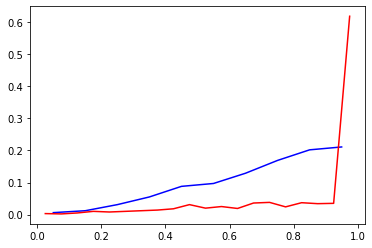

In [221]:
sim_blue.processOutput()
sim_red.processOutput()
plt.plot(sim_blue.mubins, sim_blue.energy, c='b')
plt.plot(sim_red.mubins, sim_red.energy, c='r')
plt.show()